## Klasterisasi Aktivitas dan Kinerja Akademik Menggunakan Alogirtma Average Linkage

Nama Anggota | NIM |
--- | --- |
Afif Al Dzaqwan | 225150601111023
Devan Ferrel | 225150600111031
Rahmat Aramadhan Husni | 225150607111008

### Load Dataset

Membaca file dataset menggunakan library pandas

In [77]:
import pandas as pd

# Load dataset
FILE_PATH = 'data/student_lifestyle_dataset.csv'
data = pd.read_csv(FILE_PATH)
data.head(5)

,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High


### Preprocessing

Pada langkah ini, kita ingin menormalisasikan fitur numerik dengan melakukan perubahan atau encode variabel kategori seperti Stress Level menjadi bentuk angka untuk memastikan variabel dapat dengan mudah dikomparasi. Kita juga melakukan standarisasi skala supaya tidak ada fitur yang dominan karena skala nya yang lebih besar

In [78]:
from sklearn.preprocessing import StandardScaler, LabelEncoder


stress_level_mapping = {"Low": 1, "Moderate": 2, "High": 3}
data['Stress_Level_Encoded'] = data['Stress_Level'].map(stress_level_mapping)

numerical_cols = [
    "Study_Hours_Per_Day", 
    "Extracurricular_Hours_Per_Day", 
    "Sleep_Hours_Per_Day", 
    "Social_Hours_Per_Day", 
    "Physical_Activity_Hours_Per_Day", 
    "GPA",
    'Stress_Level_Encoded'
]

data_numeric = data[numerical_cols]

# Normalize with StandardScaler 
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

data_scaled.mean(axis=0)

array([-3.15303339e-16,  1.42108547e-17,  1.77635684e-16, -1.40332190e-16,
       -5.46673817e-16,  5.22248911e-16, -1.07469589e-16])

### Klasterisasi

In [79]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

linkage_matrix = linkage(data_scaled, method='average')

c, coph_dists = cophenet(linkage_matrix, pdist(data_scaled))
c

0.5653802294969428

### Visualisasi Dendogram

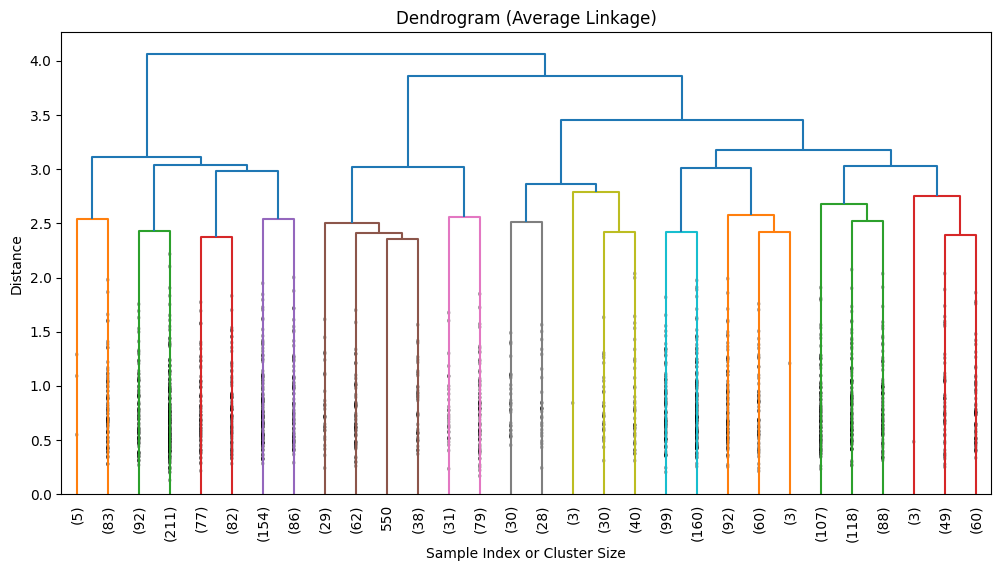

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10, show_contracted=True)
plt.title("Dendrogram (Average Linkage)")
plt.xlabel("Sample Index or Cluster Size")
plt.ylabel("Distance")
plt.show()

### Mencari jumlah kluster yang optimal

Menggunakan elbow method dan silhoutte score

#### Elbow Method

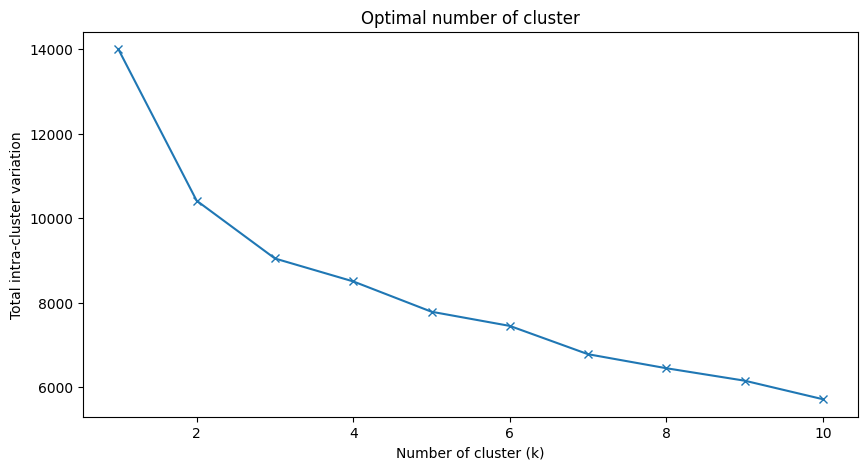

In [69]:
from sklearn.cluster import AgglomerativeClustering

def wss_calculation(K, data):
    WSS = []
    for i in range(K):
        cluster = AgglomerativeClustering(n_clusters=i+1, linkage='average')
        cluster.fit_predict(data)
        # cluster index
        label = cluster.labels_
        wss = []
        for j in range(i+1):
            # extract each cluster according to its index
            idx = [t for t, e in enumerate(label) if e == j]
            cluster = data[idx,]
            # calculate the WSS:
            cluster_mean = cluster.mean(axis=0)
            distance = np.sum(np.abs(cluster - cluster_mean)**2,axis=-1)
            wss.append(sum(distance))
        WSS.append(sum(wss))
    return WSS

WSS=wss_calculation(10, data_scaled)

cluster_range = range(1, 11)

plt.figure(figsize=(10,5))
plt.title('Optimal number of cluster')
plt.xlabel('Number of cluster (k)')
plt.ylabel('Total intra-cluster variation')
plt.plot(cluster_range, WSS, marker = "x")

Berdasarkan hasil dan pengamatan menggunakan elbow method pada diatas, maka kita mendeduksikan 3 sebagai jumlah klaster yang optimal. Hal ini dikarenakan penurunan total variasi intra-cluster sangat besar antara k = 1 hingga k = 3, namun laju penurunannya melambat secara signifikan setelah k = 3.

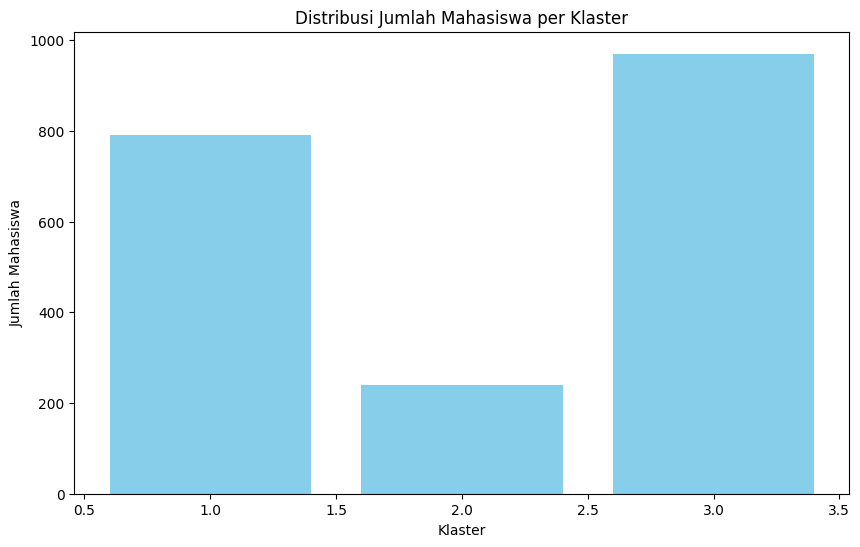

In [70]:
num_clusters = 3

clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

data['Cluster'] = clusters

numeric_columns = data.select_dtypes(include=['number']).columns

cluster_counts = data['Cluster'].value_counts().sort_index()

cluster_centers = data[numeric_columns].groupby('Cluster').mean()

plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.title("Distribusi Jumlah Mahasiswa per Klaster")
plt.xlabel("Klaster")
plt.ylabel("Jumlah Mahasiswa")
plt.show()

In [72]:
detailed_summary = data.groupby('Cluster')[numeric_columns].describe()
print(detailed_summary)


        Student_ID                                                          \
             count         mean         std   min     25%     50%      75%   
Cluster                                                                      
1            790.0   978.710127  581.171819   5.0  454.75   976.0  1480.75   
2            240.0   985.233333  577.076650  13.0  494.25   963.5  1471.75   
3            970.0  1022.023711  574.394956   1.0  556.25  1019.5  1518.75   

                Study_Hours_Per_Day            ...     GPA       Cluster       \
            max               count      mean  ...     75%   max   count mean   
Cluster                                        ...                              
1        2000.0               790.0  8.950253  ...  3.5075  4.00   790.0  1.0   
2        1992.0               240.0  6.517500  ...  3.1300  3.49   240.0  2.0   
3        1998.0               970.0  6.512062  ...  3.1200  3.75   970.0  3.0   

                                       
    

In [73]:
# Visualize GPA distribution per cluster
def visualize_distribution(col):
    plt.figure(figsize=(10, 6))
    for cluster in data['Cluster'].unique():
        cluster_data = data[data['Cluster'] == cluster]
        plt.hist(cluster_data[col], bins=10, alpha=0.5, label=f'Cluster {cluster}')
    plt.title(f"{col} Distribution per Cluster")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

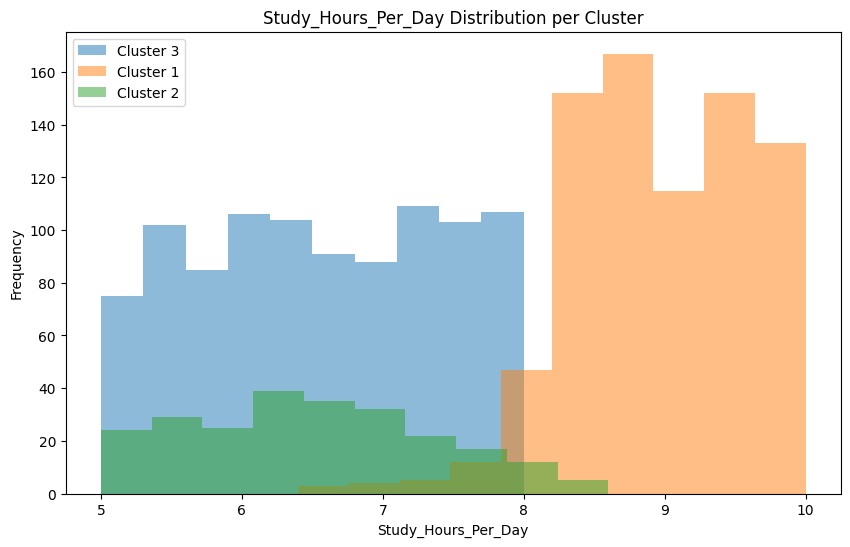

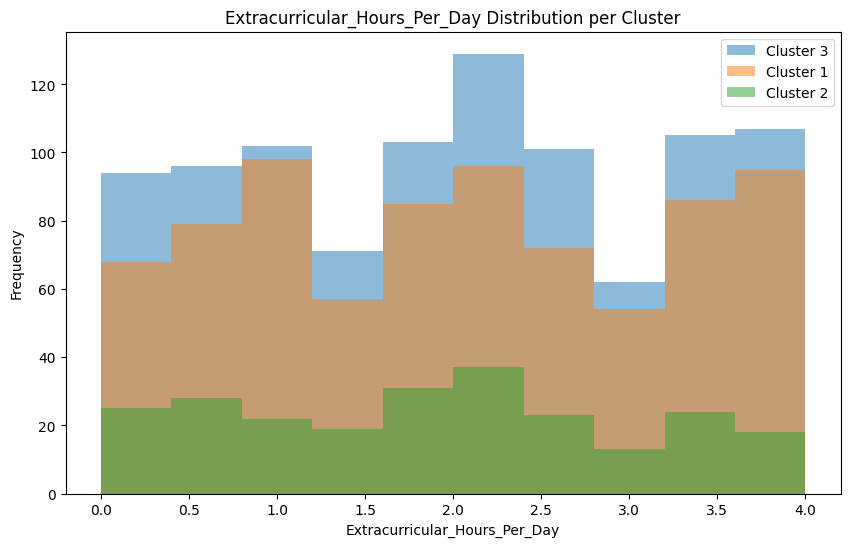

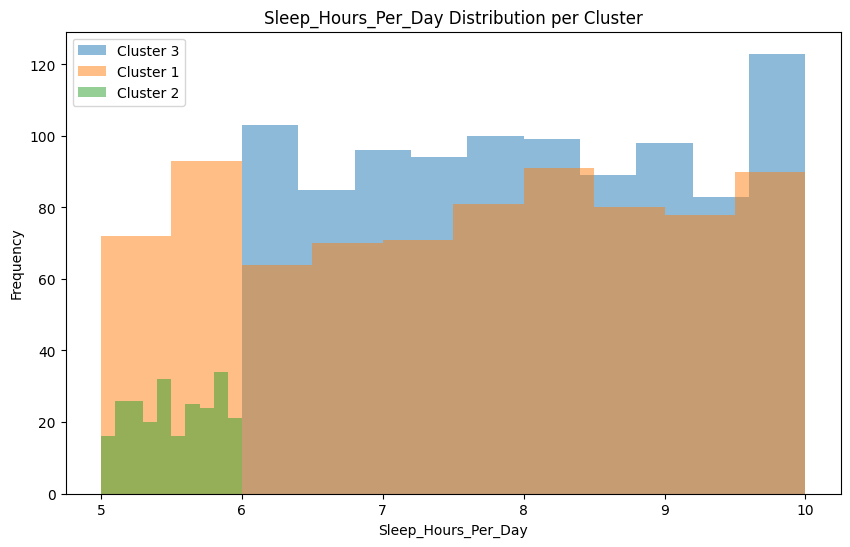

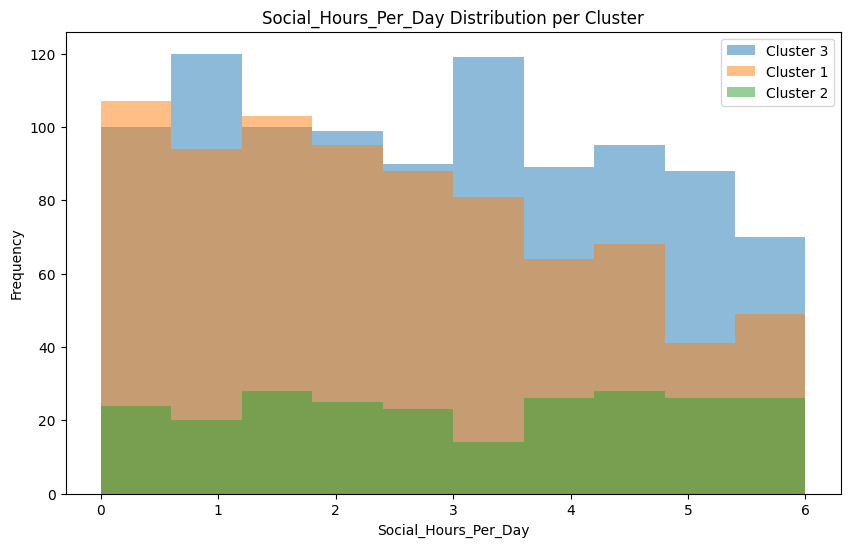

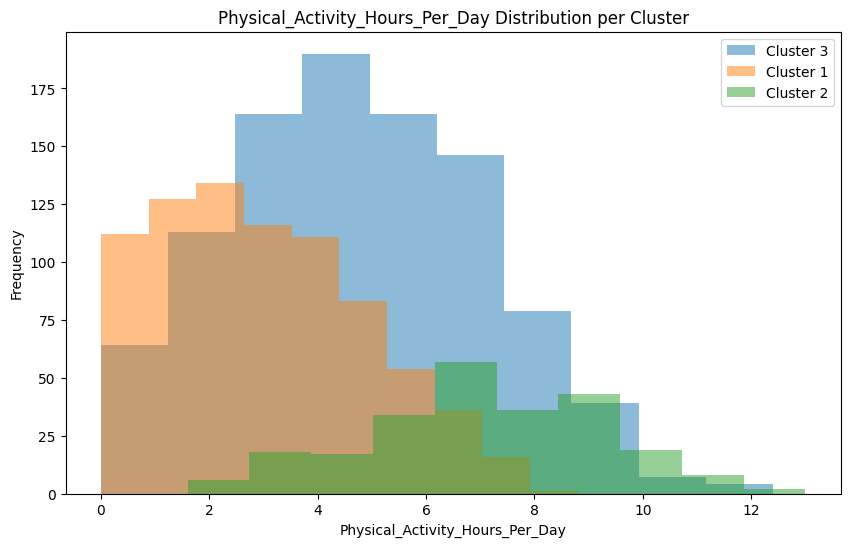

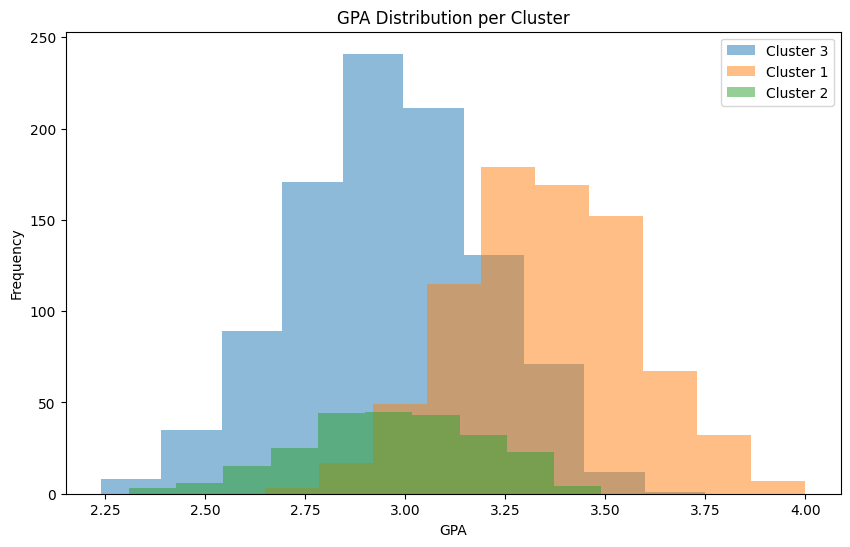

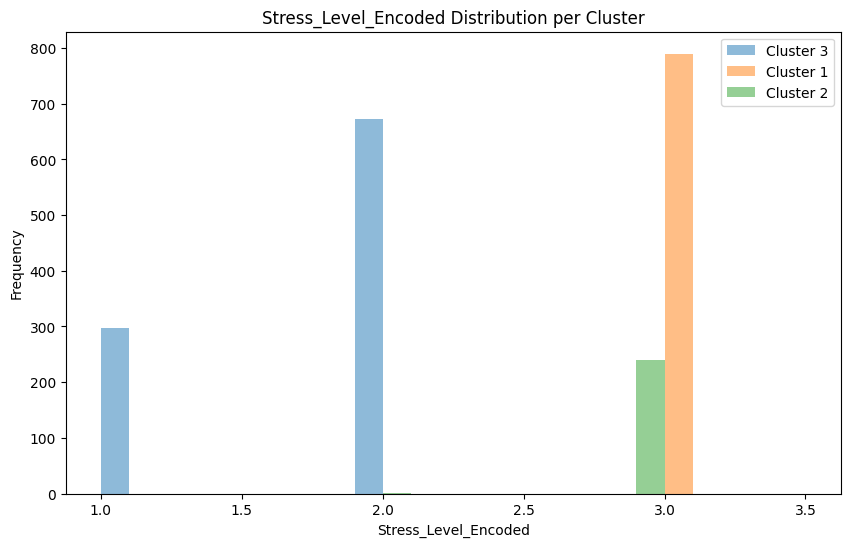

In [76]:
for num_col in numerical_cols :
    visualize_distribution(num_col)